# 上場企業の財務データ分析とクラスタリング スクリプトファイル
大学の課題レポートの一部として提出したスクリプトファイルです。

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## トヨタの財務データを取得

In [2]:
# トヨタ（7203.T）の財務データを取得
ticker = "7203.T"  # 日本株は「.T」をつける
stock = yf.Ticker(ticker)

# 財務データの取得
balance_sheet = stock.balance_sheet # 貸借対照表
income_statement = stock.financials # 損益計算書
cash_flow = stock.cashflow # キャッシュフロー計算書

# CSVに保存
balance_sheet.to_csv("toyota_balance_sheet.csv")
income_statement.to_csv("toyota_income_statement.csv")
cash_flow.to_csv("toyota_cash_flow.csv")

print(balance_sheet)

                                                        2024-03-31  \
Treasury Shares Number                                2840815433.0   
Ordinary Shares Number                               13474172027.0   
Share Issued                                         16314987460.0   
Net Debt                                          26687153000000.0   
Total Debt                                        36561781000000.0   
...                                                            ...   
Cash Cash Equivalents And Short Term Investments  14114228000000.0   
Other Short Term Investments                       4702168000000.0   
Cash And Cash Equivalents                          9412060000000.0   
Cash Equivalents                                   3166803000000.0   
Cash Financial                                     6245257000000.0   

                                                        2023-03-31  \
Treasury Shares Number                                2749807731.0   
Ordinary Shares Num

In [3]:
# ファイルの読み込み
balance_sheet = pd.read_csv("toyota_balance_sheet.csv", index_col=0)
income_statement = pd.read_csv("toyota_income_statement.csv", index_col=0)
cash_flow = pd.read_csv("toyota_cash_flow.csv", index_col=0)

# 各データの確認
print(balance_sheet.head())  # 貸借対照表
print(income_statement.head())  # 損益計算書
print(cash_flow.head())  # キャッシュフロー計算書


                          2024-03-31    2023-03-31    2022-03-31  \
Treasury Shares Number  2.840815e+09  2.749808e+09  2.536686e+09   
Ordinary Shares Number  1.347417e+10  1.356518e+10  1.377830e+10   
Share Issued            1.631499e+10  1.631499e+10  1.631499e+10   
Net Debt                2.668715e+13  2.140719e+13  1.996177e+13   
Total Debt              3.656178e+13  2.938027e+13  2.649636e+13   

                          2021-03-31  2020-03-31  
Treasury Shares Number  2.335244e+09         NaN  
Ordinary Shares Number  1.397974e+10         NaN  
Share Issued            1.631499e+10         NaN  
Net Debt                2.019789e+13         NaN  
Total Debt              2.565963e+13         NaN  
                                          2024-03-31    2023-03-31  \
Tax Effect Of Unusual Items             8.561091e+10  7.482368e+10   
Tax Rate For Calcs                      2.720000e-01  3.200000e-01   
Normalized EBITDA                       8.802138e+12  5.522169e+12   
Total

## トヨタの財務比率の計算、可視化

In [4]:
# 必要な項目の取得(使わなかった項目はコメントアウト)
current_assets = balance_sheet.loc["Current Assets"]
# other_current_assets = balance_sheet.loc["Other Current Assets"]
# total_non_current_assets = balance_sheet.loc["Total Non Current Assets"]
# other_non_current_assets = balance_sheet.loc["Other Non Current Assets"]
total_assets = balance_sheet.loc["Total Assets"]

current_liabilities = balance_sheet.loc["Current Liabilities"]
# other_current_liabilities = balance_sheet.loc["Other Current Liabilities"]
# total_non_current_liabilities = balance_sheet.loc["Total Non Current Liabilities Net Minority Interest"]
# other_non_current_liabilities = balance_sheet.loc["Other Non Current Liabilities"]
# total_liabilities_net_minority_interest = balance_sheet.loc["Total Liabilities Net Minority Interest"]

stockholders_equity = balance_sheet.loc["Stockholders Equity"]

net_income = income_statement.loc["Net Income"]


In [5]:
# 安全性に関する財務比率の計算
# 様々な比率を計算するコードを書いていたが、過度に複雑になるので流動比率と自己資本比率のみに
safety_ratios = pd.DataFrame({
    "Current Ratio": current_assets / current_liabilities, # 流動比率 = 流動資産 / 流動負債
    # "Debt Ratio": (total_liabilities_net_minority_interest) / total_non_current_assets, # 負債比率 = 負債 / 非流動資産
    "Equity Ratio": stockholders_equity / (total_assets) # 自己資本比率 = 自己資本 / 資産
})

# 結果の表示
print(safety_ratios)

            Current Ratio  Equity Ratio
2024-03-31       1.189745      0.379751
2023-03-31       1.104345      0.381393
2022-03-31       1.086078      0.387745
2021-03-31       1.061338      0.375873
2020-03-31            NaN           NaN


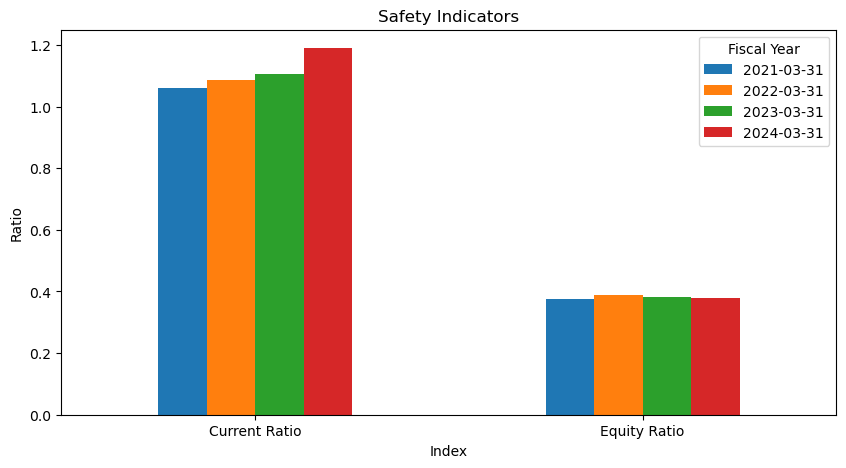

In [6]:
# 安全性に関する財務比率の棒グラフ
safety_ratios = safety_ratios.dropna() # 欠損値を削除
safety_ratios = safety_ratios.sort_index() # 新しいデータが右に来るように並び替え
safety_ratios.T.plot(kind="bar", figsize=(10, 5))
plt.title("Safety Indicators")
plt.ylabel("Ratio")
plt.xlabel("Index")
plt.xticks(rotation=0)
plt.legend(title="Fiscal Year")
plt.show()

一般的に流動比率は2以上が目安で1を下回ると短期的な資金繰りに問題があるとされるが、過大な現金預金等の保有は収益性を犠牲にした過度な安全性となり、一概に高ければ高いほど良いというわけではない。自己資本比率は40%以上なら財務の安定性が高いとされる。

In [7]:
# 収益性に関する財務比率の計算
# ROE・ROAの計算（前期と当期の平均を分母にする）
roe = net_income / ((stockholders_equity.shift(-1) + stockholders_equity) / 2)
roa = net_income / ((total_assets.shift(-1) + total_assets) / 2)

# ROE・ROAのデータフレームを作成
roe_roa_df = pd.DataFrame({
    "ROE": roe,
    "ROA": roa
})

# 結果の表示
print(roe_roa_df)

                 ROE       ROA
2024-03-31  0.158087  0.060151
2023-03-31  0.089817  0.034528
2022-03-31  0.114807  0.043863
2021-03-31       NaN       NaN
2020-03-31       NaN       NaN


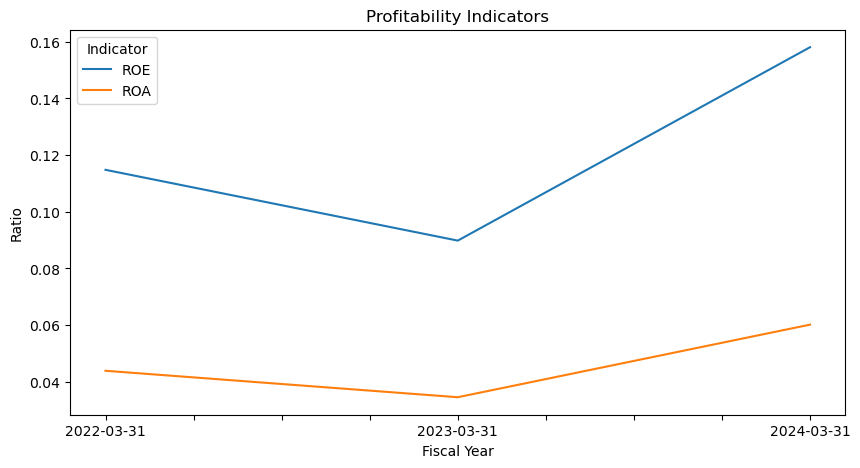

In [8]:
# 収益性に関する財務比率の折れ線グラフ
roe_roa_df = roe_roa_df.sort_index(ascending=True) # 新しいデータが右に来るように並び替え
roe_roa_df.plot(figsize=(10, 5))
plt.title("Profitability Indicators")
plt.ylabel("Ratio")
plt.xlabel("Fiscal Year")
plt.legend(title="Indicator")
plt.show()

一般的にROEは8~10%以上であれば、ROAは5%以上であれば、効率的に稼いでいるといわれる。

## クラスタリング

In [9]:
# クラスタリングするにあたって、トヨタ、ホンダ、日産、スズキ、マツダのデータを取得
# 企業リスト（トヨタ, ホンダ, 日産, スズキ, マツダ）
companies = {
    "Toyota": "7203.T",
    "Honda": "7267.T",
    "Nissan": "7201.T",
    "Suzuki": "7269.T",
    "Mazda": "7261.T"
}

# 各企業の財務データを取得
financial_data = {}

for name, ticker in companies.items():
    stock = yf.Ticker(ticker)
    
    # 貸借対照表・損益計算書を取得
    balance_sheet = stock.balance_sheet
    income_statement = stock.financials

    # 必要なデータを取得（エラーハンドリング付き）
    try:
        current_assets = balance_sheet.loc["Current Assets"]
        current_liabilities = balance_sheet.loc["Current Liabilities"]
        total_assets = balance_sheet.loc["Total Assets"]
        stockholders_equity = balance_sheet.loc["Stockholders Equity"]
        net_income = income_statement.loc["Net Income"]
        
        # 財務比率の計算
        ratios = pd.DataFrame({
            "Current Ratio": current_assets / current_liabilities,
            "Equity Ratio": stockholders_equity / total_assets,
            "ROE": net_income / ((stockholders_equity + stockholders_equity.shift(-1)) / 2),
            "ROA": net_income / ((total_assets + total_assets.shift(-1)) / 2)
        }).dropna()

        # 結果を保存
        financial_data[name] = ratios

    except KeyError:
        print(f"{name} のデータ取得に失敗しました")

# すべての企業データを統合
financial_ratios = pd.concat(financial_data, names=["Company", "Year"])

# データの確認
print(financial_ratios)

                   Current Ratio Equity Ratio       ROE       ROA
Company Year                                                     
Toyota  2024-03-31      1.189745     0.379751  0.158087  0.060151
        2023-03-31      1.104345     0.381393  0.089817  0.034528
        2022-03-31      1.086078     0.387745  0.114807  0.043863
Honda   2024-03-31      1.426392     0.426444  0.092723  0.040672
        2023-03-31      1.439893     0.453353  0.060157  0.026783
        2022-03-31      1.472491     0.436856  0.072315  0.030813
Nissan  2024-03-31      1.859927      0.30128  0.076757  0.022783
        2023-03-31      1.679371      0.29178  0.045679  0.013064
        2022-03-31      1.679254     0.279791  0.050564  0.013133
Suzuki  2022-03-31      1.632464     0.452033  0.089933  0.039149
        2023-03-31      1.471335     0.453951  0.111774  0.050638
        2024-03-31        1.4001     0.462538  0.117186   0.05374
Mazda   2022-03-31      1.621715     0.438516  0.065674  0.027714
        20

In [10]:
# 企業名と年度をリセットし、整理する
df = financial_ratios.reset_index()

# 必要な指標だけを取り出す
df_clustering = df[["Company", "Current Ratio", "Equity Ratio", "ROE", "ROA"]].copy()

# データの確認
print(df_clustering.head())

  Company Current Ratio Equity Ratio       ROE       ROA
0  Toyota      1.189745     0.379751  0.158087  0.060151
1  Toyota      1.104345     0.381393  0.089817  0.034528
2  Toyota      1.086078     0.387745  0.114807  0.043863
3   Honda      1.426392     0.426444  0.092723  0.040672
4   Honda      1.439893     0.453353  0.060157  0.026783


In [11]:
from sklearn.preprocessing import StandardScaler

# 数値データのみ抽出（企業名を除く）
features = df_clustering.drop(columns=["Company"])

# 標準化
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

c:\Users\yubas\miniconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\yubas\miniconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\yubas\miniconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\yubas\miniconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

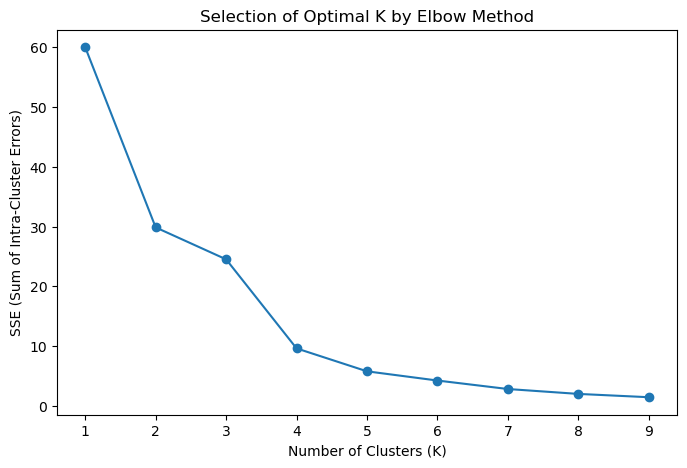

In [12]:
from sklearn.cluster import KMeans

# クラスタ数（K）を変えながら誤差を計算
inertia = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# エルボー法のプロット
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("SSE (Sum of Intra-Cluster Errors)")
plt.title("Selection of Optimal K by Elbow Method")
plt.show()

In [13]:
# 適切なクラスタ数（エルボー法の結果を見て選択）
optimal_k = 4

# K-Meansクラスタリング
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_clustering["Cluster"] = kmeans.fit_predict(features_scaled)

# # クラスタごとの平均値を確認 (エラーが起きるためコメントアウト)
# cluster_summary = df_clustering.groupby("Cluster").mean()
# print(cluster_summary) 

# 数値データのみを使用して groupby().mean() を実行
cluster_summary = df_clustering.drop(columns=["Company"]).groupby("Cluster").mean()

# 結果を表示
print(cluster_summary)

        Current Ratio Equity Ratio       ROE       ROA
Cluster                                               
0            1.518591      0.44144  0.076161  0.033026
1            1.369229     0.439292  0.124386  0.053862
2            1.095211     0.384569  0.102312  0.039195
3            1.739517      0.29095  0.057667  0.016327


c:\Users\yubas\miniconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [14]:
# 各企業のクラスタを表示
print(df_clustering[["Company", "Cluster"]].sort_values("Cluster"))

   Company  Cluster
3    Honda        0
4    Honda        0
5    Honda        0
9   Suzuki        0
12   Mazda        0
0   Toyota        1
10  Suzuki        1
11  Suzuki        1
13   Mazda        1
14   Mazda        1
1   Toyota        2
2   Toyota        2
6   Nissan        3
7   Nissan        3
8   Nissan        3


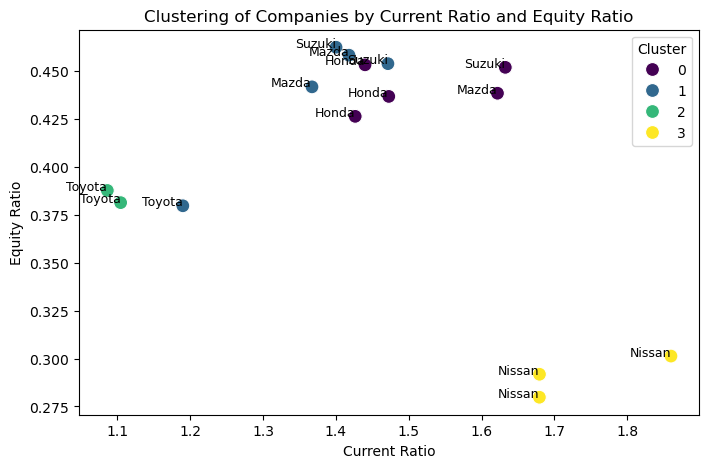

In [15]:
# 流動比率と自己資本比率のクラスタリング
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(
    x=df_clustering["Current Ratio"], y=df_clustering["Equity Ratio"],
    hue=df_clustering["Cluster"], palette="viridis", s=100
)

# 各点に企業名を表示
for i, row in df_clustering.iterrows():
    plt.text(row["Current Ratio"], row["Equity Ratio"], row["Company"], fontsize=9, ha='right')

plt.xlabel("Current Ratio")
plt.ylabel("Equity Ratio")
plt.title("Clustering of Companies by Current Ratio and Equity Ratio")
plt.legend(title="Cluster")
plt.show()

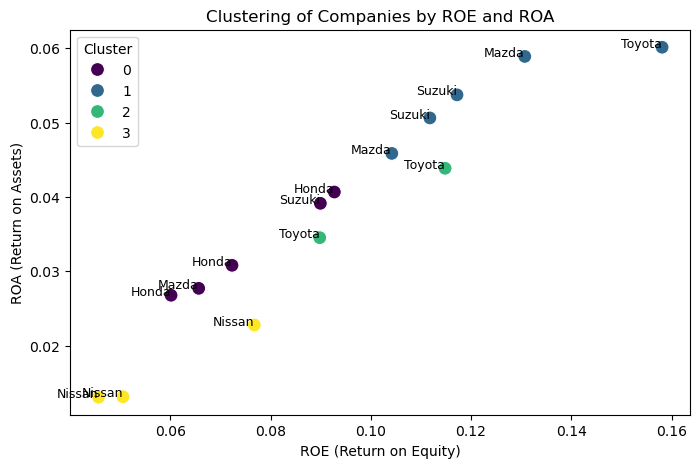

In [16]:
# ROEとROAのクラスタリング
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(
    x=df_clustering["ROE"], y=df_clustering["ROA"],
    hue=df_clustering["Cluster"], palette="viridis", s=100
)

# 各点に企業名を表示
for i, row in df_clustering.iterrows():
    plt.text(row["ROE"], row["ROA"], row["Company"], fontsize=9, ha='right')

plt.xlabel("ROE (Return on Equity)")
plt.ylabel("ROA (Return on Assets)")
plt.title("Clustering of Companies by ROE and ROA")
plt.legend(title="Cluster")
plt.show()

In [17]:
# 企業ごとのクラスタリング結果を表示
print(df_clustering)

   Company Current Ratio Equity Ratio       ROE       ROA  Cluster
0   Toyota      1.189745     0.379751  0.158087  0.060151        1
1   Toyota      1.104345     0.381393  0.089817  0.034528        2
2   Toyota      1.086078     0.387745  0.114807  0.043863        2
3    Honda      1.426392     0.426444  0.092723  0.040672        0
4    Honda      1.439893     0.453353  0.060157  0.026783        0
5    Honda      1.472491     0.436856  0.072315  0.030813        0
6   Nissan      1.859927      0.30128  0.076757  0.022783        3
7   Nissan      1.679371      0.29178  0.045679  0.013064        3
8   Nissan      1.679254     0.279791  0.050564  0.013133        3
9   Suzuki      1.632464     0.452033  0.089933  0.039149        0
10  Suzuki      1.471335     0.453951  0.111774  0.050638        1
11  Suzuki        1.4001     0.462538  0.117186   0.05374        1
12   Mazda      1.621715     0.438516  0.065674  0.027714        0
13   Mazda       1.36706     0.441842  0.104181  0.045866     

- クラスタ0にはホンダ、スズキ、マツダが当てはまる。流動比率・自己資本比率が高く、ROEはやや低めで、安定型企業といえる。
- クラスタ1にはトヨタ、スズキ、マツダが当てはまる。ROE・ROAが高く、収益性の高い企業といえる。
- クラスタ2にはトヨタが当てはまる。流動比率は低いものの、収益性も一定レベルを維持しており、ほかの企業と比較してバランス型企業といえる。
- クラスタ3は明らかに異質で、日産が当てはまる。流動比率は高いが自己資本比率が低く、またROA・ROEも低い。負債に依存した低収益な企業といえる。